# **Creating a Classification Model using CoronaBERT**

The purpose of this colab is to create a classification model to predict the relevance on documents, using the qrels for training, validation and testing data.  The queries and documents will be encoded using CoronaBERT.  The training data makes use of all the judgements made at round 4 of TREC-COVID, whereas the testing data makes use of the judgements made in round 5.

## **Setup**

In [ ]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.utils import resample

In [ ]:
#get all the doc embeddings - the process of doc encoding is performed in a complementary colab

!wget https://github.com/DavidONeill75101/level-4-project/blob/master/Datasets/coronaBERT_Embeddings/coronaBERT_doc_embeddings.pickle?raw=true

with open('/content/coronaBERT_doc_embeddings.pickle?raw=true', 'rb') as f:
  doc_embeddings = pickle.load(f)

In [ ]:
len(doc_embeddings)

191175

In [ ]:
#get all the query embeddings - the process of query encoding is performed in a complementary colab

!wget https://github.com/DavidONeill75101/level-4-project/blob/master/Datasets/coronaBERT%20Embeddings/coronaBERT_query_embeddings.pickle?raw=true
with open('/content/coronaBERT_query_embeddings.pickle?raw=true', 'rb') as f:
  query_embeddings = pickle.load(f)

In [ ]:
len(query_embeddings)

50

In [ ]:
!wget https://raw.githubusercontent.com/DavidONeill75101/level-4-project/master/Datasets/DataSplit/training_validation_data.csv
training_qrels = pd.read_csv('/content/training_validation_data.csv').drop(columns=['Unnamed: 0'])

In [ ]:
len(training_qrels)

46203

In [ ]:
!wget https://raw.githubusercontent.com/DavidONeill75101/level-4-project/master/Datasets/DataSplit/testing_data.csv
test_qrels = pd.read_csv('/content/testing_data.csv').drop(columns=['Unnamed: 0'])

In [ ]:
len(test_qrels)

23151

As there is some ambiguity around the validity of the "partially relevant" judgements, we will only consider the documents which are either "not relevant" or "full relevant".

In [ ]:
training_qrels = training_qrels[training_qrels['label'].isin([0,2])]

In [ ]:
len(training_qrels)

39377

In [ ]:
test_qrels = test_qrels[test_qrels['label'].isin([0,2])]

In [ ]:
len(test_qrels)

18916

In [ ]:
#concatenate the query and document embeddings for every row in the training qrels

training_queries = list(training_qrels['qid'])
training_docnos = list(training_qrels['docno'])
training_labels = list(training_qrels['label'])

X_train = []
y_train = []

for query, docno, label in zip(training_queries, training_docnos, training_labels):
  
  try:
    query_embedding = query_embeddings[str(query)]
    doc_embedding = doc_embeddings[docno]
    input = np.concatenate([query_embedding, doc_embedding])

    X_train.append(input)
    y_train.append(label)

  except:
    print("No embedding")
  


No embedding
No embedding
No embedding
No embedding
No embedding
No embedding
No embedding
No embedding
No embedding
No embedding
No embedding
No embedding
No embedding
No embedding
No embedding
No embedding
No embedding
No embedding
No embedding
No embedding
No embedding
No embedding
No embedding
No embedding
No embedding
No embedding
No embedding
No embedding
No embedding
No embedding
No embedding
No embedding


In [ ]:
len(X_train)==len(y_train)

True

Take a look at the class imbalance of the training data.

In [ ]:
imbalanced_counts = pd.Series(y_train).value_counts().values


In [ ]:
X_train = np.array(X_train)
y_train = np.array(y_train)
X_oversampled, y_oversampled = resample(X_train[y_train == 2],
                                        y_train[y_train == 2],
                                        replace=True,
                                        n_samples=X_train[y_train == 0].shape[0],
                                        random_state=123)

In [ ]:
X_train = list(X_train)
X_oversampled = list(X_oversampled)
X_train = X_train+X_oversampled

y_train = list(y_train)
y_oversampled = list(y_oversampled)
y_train = y_train+y_oversampled

In [ ]:
pd.Series(y_train).value_counts()

2    39345
0    30413
dtype: int64

Text(0.5, 0, 'Class')

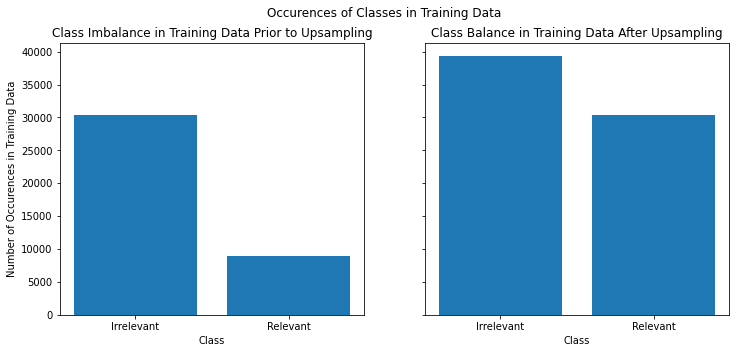

In [ ]:
balanced_counts = pd.Series(y_train).value_counts().values

fig, ax = plt.subplots(1,2, sharey=True, sharex=True, figsize=(12, 5))
fig.suptitle("Occurences of Classes in Training Data")

ax[0].bar(['Irrelevant', 'Relevant'], imbalanced_counts)
ax[0].set_title("Class Imbalance in Training Data Prior to Upsampling")
ax[0].set_xlabel("Class")
ax[0].set_ylabel("Number of Occurences in Training Data")

ax[1].bar(['Irrelevant', 'Relevant'], balanced_counts)
ax[1].set_title("Class Balance in Training Data After Upsampling")
ax[1].set_xlabel("Class")

We now have our training data - the list of concatenated query and doc embeddings - and our training labels - the corresponding relevance judgements.

Next we need to define a model on which to train these qrels - we will begin with a dense neural network.

First we will scale the data.

In [ ]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)

In [ ]:
len(X_train)==len(y_train)

True

Now we will do the same with the test qrels.

In [ ]:
test_queries = list(test_qrels['qid'])
test_docnos = list(test_qrels['docno'])
test_labels = list(test_qrels['label'])



X_test = []
y_test = []

for query, docno, label in zip(test_queries, test_docnos, test_labels):
  
  try:
    query_embedding = query_embeddings[str(query)]
    doc_embedding = doc_embeddings[docno]
    input = np.concatenate([query_embedding, doc_embedding])

    X_test.append(input)
    y_test.append(label)

  except:
    print("No embedding")
  


In [ ]:
sc = StandardScaler()
X_test = sc.fit_transform(X_test)

## **Creating the model**

In [ ]:
classifier = MLPClassifier(hidden_layer_sizes=(150,100,50), max_iter=300,activation = 'relu',solver='adam',random_state=1, verbose=True)

In [ ]:
import torch
device = "cuda:0" if torch.cuda.is_available() else "cpu"
print(device)

cuda:0


In [ ]:
classifier.fit(X_train, y_train)

Iteration 1, loss = 0.44711661
Iteration 2, loss = 0.39078303
Iteration 3, loss = 0.36502340
Iteration 4, loss = 0.34424133
Iteration 5, loss = 0.33007368
Iteration 6, loss = 0.31535308
Iteration 7, loss = 0.30262514
Iteration 8, loss = 0.29154998
Iteration 9, loss = 0.28438095
Iteration 10, loss = 0.27438457
Iteration 11, loss = 0.26625753
Iteration 12, loss = 0.25844786
Iteration 13, loss = 0.25082122
Iteration 14, loss = 0.24587178
Iteration 15, loss = 0.23774624
Iteration 16, loss = 0.23342515
Iteration 17, loss = 0.22890244
Iteration 18, loss = 0.22367687
Iteration 19, loss = 0.22001757
Iteration 20, loss = 0.21432909
Iteration 21, loss = 0.21110035
Iteration 22, loss = 0.20817311
Iteration 23, loss = 0.20447646
Iteration 24, loss = 0.19926428
Iteration 25, loss = 0.19751869
Iteration 26, loss = 0.19447522
Iteration 27, loss = 0.19281588
Iteration 28, loss = 0.18981249
Iteration 29, loss = 0.18515619
Iteration 30, loss = 0.18385538
Iteration 31, loss = 0.18355834
Iteration 32, los

MLPClassifier(hidden_layer_sizes=(150, 100, 50), max_iter=300, random_state=1,
              verbose=True)

In [ ]:
#get the test predictions
y_true, y_pred = y_test , classifier.predict(X_test)

In [ ]:
#show the results on the test set
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.74      0.77     12239
           2       0.59      0.68      0.63      6677

    accuracy                           0.72     18916
   macro avg       0.70      0.71      0.70     18916
weighted avg       0.73      0.72      0.72     18916



## **Hyperparameter Tuning**

In [ ]:
param_grid = {
    'hidden_layer_sizes': [(150,100,50), (120,80,40), (100,50,30)],
    'max_iter': [100],
    'activation': ['relu'],
    'solver': ['adam'],
}

In [ ]:
grid = GridSearchCV(classifier, param_grid, n_jobs= -1, cv=5)
grid.fit(X_train, y_train)

print(grid.best_params_) 

{'activation': 'relu', 'hidden_layer_sizes': (150, 100, 50), 'max_iter': 100, 'solver': 'adam'}


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


In [ ]:
grid_predictions = grid.predict(X_test) 

In [ ]:
print(classification_report(y_test, grid_predictions))

              precision    recall  f1-score   support

           0       0.77      0.86      0.81     12239
           2       0.67      0.53      0.60      6677

    accuracy                           0.74     18916
   macro avg       0.72      0.70      0.70     18916
weighted avg       0.74      0.74      0.74     18916

